In [24]:
#do not change
import sys
import os
from time import time
%matplotlib inline
from urllib.request import urlopen
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
#from scipy.misc import imsave
import math

def load_mnist():
    images_url = 'https://github.com/guptashvm/Data/blob/master/data/train-images-idx3-ubyte?raw=true'
    with urlopen(images_url) as urlopened:
      fd = urlopened.read()
      loaded = np.frombuffer(fd,dtype=np.uint8)
      trX = loaded[16:].reshape((60000,28*28)).astype(float)

    labels_url = 'https://github.com/guptashvm/Data/blob/master/data/train-labels-idx1-ubyte?raw=true'
    with urlopen(labels_url) as urlopened:
      fd = urlopened.read()
      loaded = np.frombuffer(fd,dtype=np.uint8)
      trY = loaded[8:].reshape((60000))

    trY = np.asarray(trY)

    X = trX / 255.
    y = trY

    subset  = [i for i, t in enumerate(y) if t in [1, 0, 2, 3]]
    X, y = X.astype('float32')[subset], y[subset]
    return X[:1000], y[:1000]

Run the following code to load the data we need. Here, **X** is the array of images, **y** is the array of labels, and **X2d** is the array of projections of the images into two-dimensional space using PCA. The two-dimensional scatterplot of the top two principal components of the images is displayed, where the color of each point represents its label.

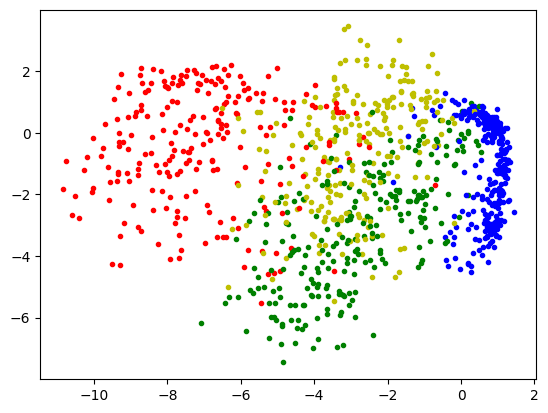

In [23]:
X, y = load_mnist()
pca = PCA(n_components=2)
pca.fit(X)
X2d = X.dot(pca.components_.T)

def plot_with_colors(Xs, ys):
  for i, _ in enumerate(ys):
    if ys[i] == 0:
      plt.plot([Xs[i, 0]], [Xs[i, 1]], 'r.')
    elif ys[i] == 1:
      plt.plot([Xs[i, 0]], [Xs[i, 1]], 'b.')
    elif ys[i] == 2:
      plt.plot([Xs[i, 0]], [Xs[i, 1]], 'g.')
    elif ys[i] == 3:
      plt.plot([Xs[i, 0]], [Xs[i, 1]], 'y.')
  plt.show()

plot_with_colors(X2d, y)

(a) Implement the standard k-means algorithm. Please complete the function __kmeans__ defined below. You are NOT allowed to use any existing code of **kmeans** for this problem.

In [27]:
def kmeans(X, k = 4, max_iter = 500, random_state=0):
  """
  Inputs:
      X: input data matrix, numpy array with shape (n * d), n: number of data points, d: feature dimension
      k: number of clusters
      max_iters: maximum iterations
  Output:
      clustering label for each data point
  """
  assert len(X) > k, 'illegal inputs'
  np.random.seed(random_state)

  # randomly select k data points as centers
  idx = np.random.choice(len(X), k, replace=False)
  centers = X[idx]

  # please complete the following code:
  from scipy.spatial import distance
  for i in range(max_iter):
      H = distance.cdist(X, centers, 'euclidean')
      # update clustering labels
      labels = np.argmin(H, axis=1)

      new_centers = centers.copy()

      # update new centers
      for j in range(k):
          cluster_points = X[labels==j]
          if len(cluster_points) > 0:
            new_centers[j] = np.mean(cluster_points, axis=0)
          else:
            new_centers[j] = X[np.random.randint(len(X))]

      # Check for convergence
      if np.allclose(centers, new_centers, rtol=1e-6):
            break

      centers = new_centers

  return labels

(b) Run your **kmeans** function on the dataset (of the top two PCA components given by array X2d). Set the number of clusters to 4. Visualize the result by coloring the 2D points in (a) according to their **clustering labels** returned by your **kmeans** algorithm. Because **kmeans** is sensitive to initialization, repeat your **kmeans** at least 5 times with different random initializations and show the plot of each initialization.

To quantitatively evaluate the clustering performance, we evaluate the $\textit{unsupervised clustering accuracy}$, which can be written as follows,
$$
\text{accuracy} = \max_{\mathcal M} \frac{\sum_{i=1}^{n} \mathbb{I}(y_i = \mathcal M(z_i))}{n}, n = 1000,
$$
where $y_i$ is the ground-truth label, $z_i$ is the cluster assignment produced by the algorithm,
and $\mathcal M$ ranges over all possible one-to-one mapping between clusters and labels and $\mathbb{I}(x)$
is a indicator function ($\mathbb{I}(x) = 1 \text{if}~x=1; \text{otherwise} ~0$).
Please use the __accuracy_score__ function defined below to calculate the accuracy.
Report the best clustering accuracy you get out of 10 random initializations.

In [32]:
# do not change
def accuracy_score(y_true, y_pred):
    """
    Calculate clustering accuracy.
        y_true: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    assert y_true.shape == y_pred.shape, 'illegal inputs'

    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[row_ind[i], col_ind[i]] for i in range(len(row_ind))]) * 1.0 / y_pred.size

Run 1 (random_state=0): Accuracy = 0.7450
Run 2 (random_state=1): Accuracy = 0.7430
Run 3 (random_state=2): Accuracy = 0.7450
Run 4 (random_state=3): Accuracy = 0.7430
Run 5 (random_state=4): Accuracy = 0.7430
Run 6 (random_state=5): Accuracy = 0.7450
Run 7 (random_state=6): Accuracy = 0.7450
Run 8 (random_state=7): Accuracy = 0.7430
Run 9 (random_state=8): Accuracy = 0.7450
Run 10 (random_state=9): Accuracy = 0.7430


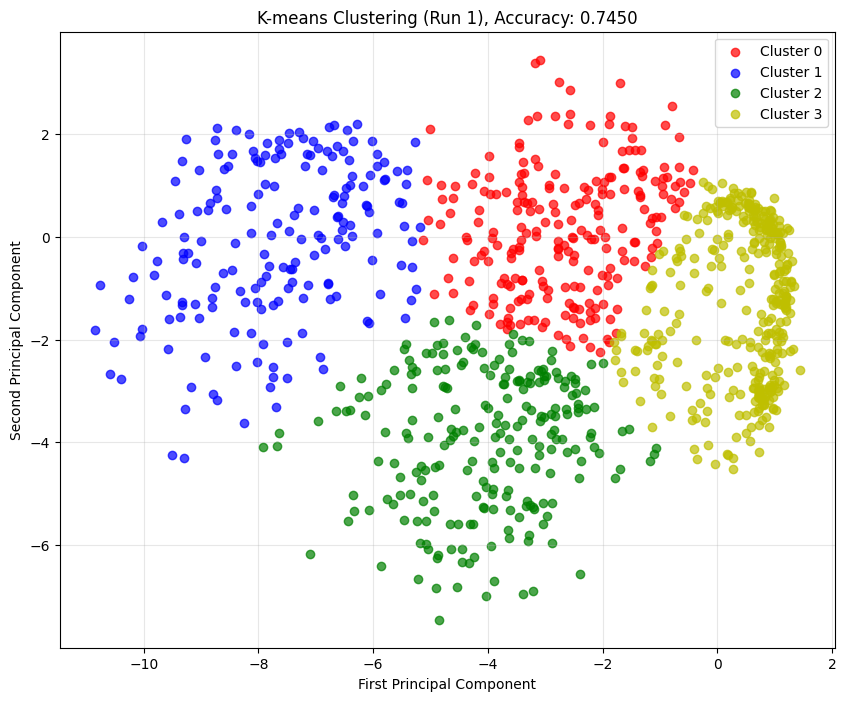

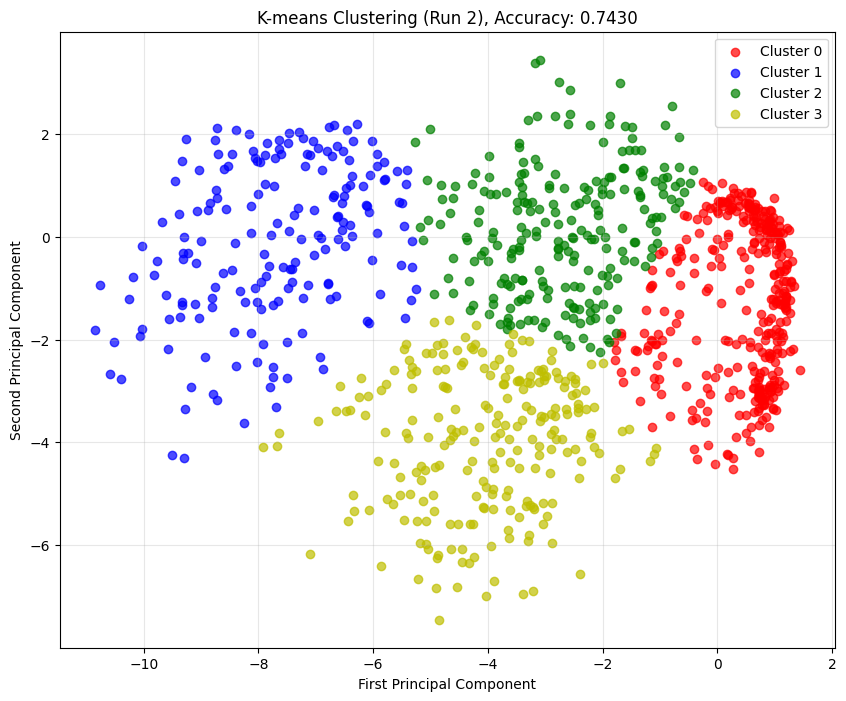

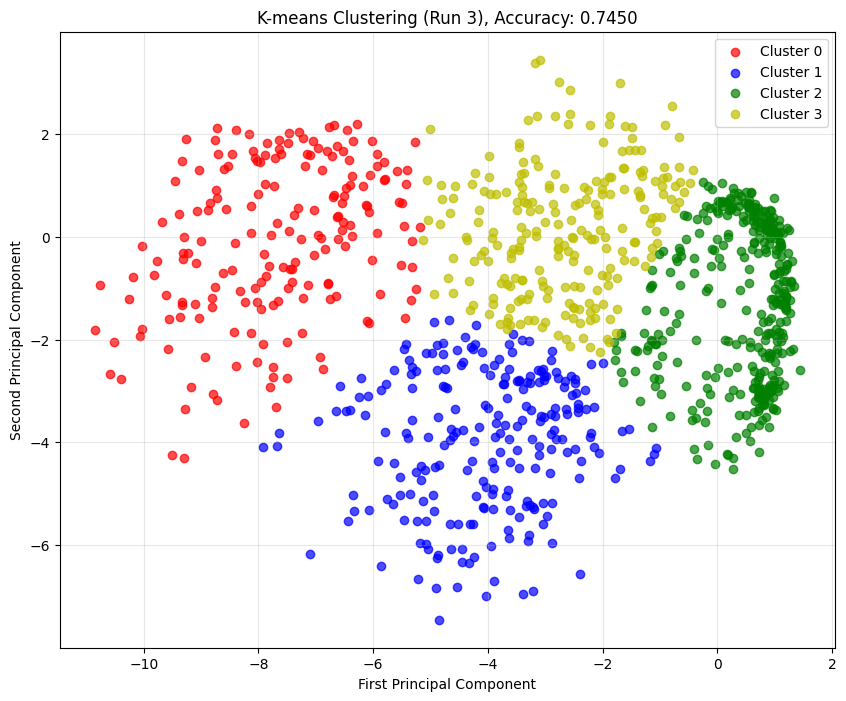

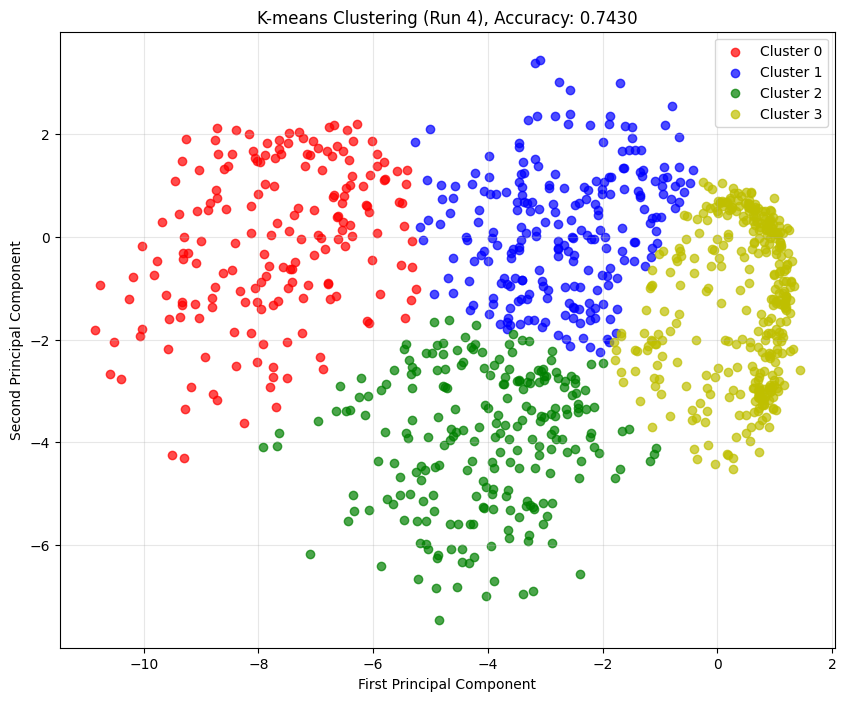

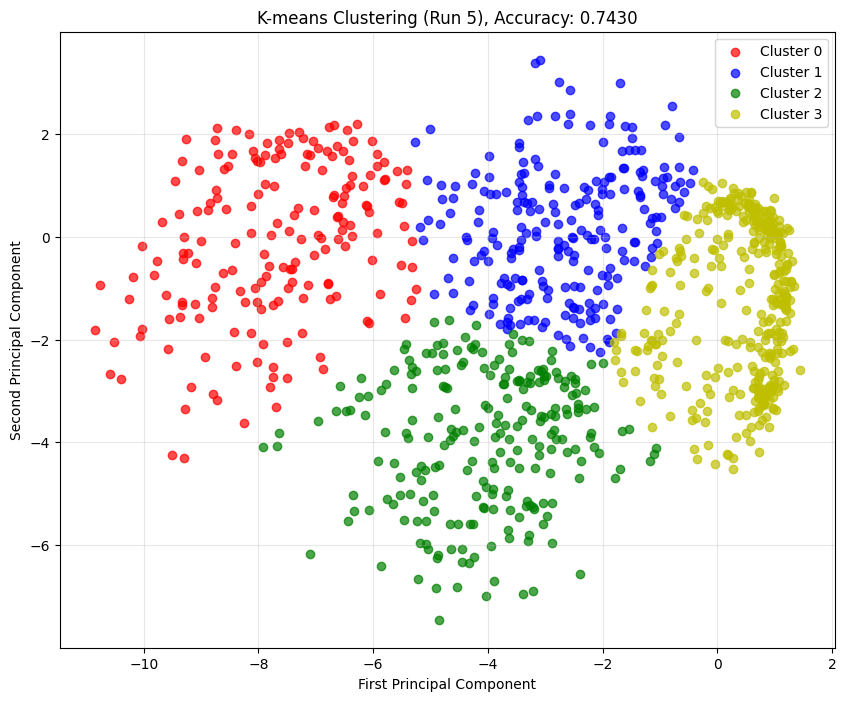

In [33]:
best_accuracy_2d = 0
best_label_2d = None


for i in range(10):
  labels = kmeans(X2d, k=4, random_state= i)
  accuracy = accuracy_score(y, labels)

  print(f"Run {i+1} (random_state={i}): Accuracy = {accuracy:.4f}")

  if accuracy > best_accuracy_2d:
    best_accuracy_2d = accuracy
    best_label_2d = labels

  #plot first 5 initializations as required

  if i < 5:
    plt.figure(figsize=(10, 8))
    plot_with_colors(X2d, labels)
    plt.title(f'K-means Clustering (Run {i+1}), Accuracy: {accuracy:.4f}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.grid(True, alpha=0.3)




We have been testing $\textit{k}$-means on the top two principal components for the purpose of visualization.
Please run $\textit{k}$-means on the  (784 dimensional) original image dataset (again using 4 clusters).
Try at least 10 different random initializations and report the best accuracy as above.

In [37]:
best_accuracy_orig=0
best_labels_orig=None

for i in range(10):
  labels = kmeans(X, k=4, random_state=i)
  accuracy  = accuracy_score(y, labels)

  if accuracy > best_accuracy_orig:
    best_accuracy_orig = accuracy
    best_labels_orig = labels

print(f"Best accuracy on original data: {best_accuracy_orig:.4f}")


Best accuracy on original data: 0.8610
